In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


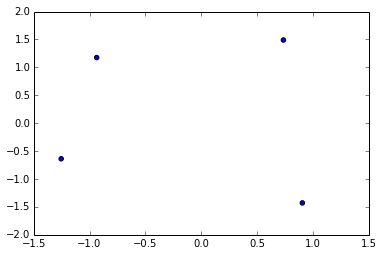

In [10]:
n = 4
x = randn(2*n).reshape(n,2)
scatter(x[:,0], x[:,1]);

In [11]:
class Cluster(object):
    def __init__(self, nodes, weights, degrees, perimeter = None, area = None):
        self.nodes = nodes.astype(float)
        self.weights = weights.astype(float)
        self.degrees = degrees #this never changes       
        if(perimeter == None):
            if(sum(self.nodes) != 1):
                raise IndexError
            self.perimeter = sum(self.weights)
        else:
            self.perimeter = perimeter
        if(area == None):
            self.area = 0
        else:
            self.area = area
        self.parent = None
        self.parentId = None
            
    def get_closest(self):
        if(sum(self.nodes) == len(self.nodes)):
            raise IndexError
        if(sum(self.weights) == 0):
            raise IndexError
        if (self.parent == None):
            temp_perimeter = self.perimeter - 2*self.weights + self.degrees
            temp_area = self.area + self.weights 
            ratios = temp_area / (temp_perimeter + 0.000001)
            next_vertex = np.argmax(ratios * np.logical_not(self.nodes))
            this_alpha = (self.area*temp_perimeter[next_vertex])/(self.perimeter*temp_area[next_vertex]) 
            return (next_vertex, temp_area[next_vertex], temp_perimeter[next_vertex], this_alpha)
        else:
            return self.parent.get_closest()
        
    def get_alpha(self, other_node):
        if(sum(self.nodes) == len(self.nodes)):
            raise IndexError
        if(sum(self.weights) == 0):
            raise IndexError
        if (self.parent == None):
            temp_perimeter = self.perimeter - 2*self.weights[other_node] + self.degrees[other_node]
            temp_area = self.area + self.weights[other_node] 
            this_alpha = (self.area*temp_perimeter)/(self.perimeter*temp_area) 
            return this_alpha
        else:
            return self.parent.get_alpha(other_node)
        
        
    def add_nodes(self, node_vector, weight):
        node_vector = node_vector.astype(float)
        if(sum(np.logical_and(self.nodes,node_vector)) != 0):
            raise IndexError

        self.weights = self.weights + weight.astype(float)
        self.nodes = self.nodes + node_vector
        self.area = sum(self.weights*self.nodes)/2.0
        self.perimeter = sum(self.weights) - 2*self.area
        
    def readable_nodes(self):
        out = []
        for i in range(len(self.nodes)):
            if(self.nodes[i] == 1):
                out.append(i)
        return out

        
        

In [12]:
seed(123)
n = 20
x = randn(2*n).reshape(n,2)
def gauss_sim(x,y, sigma = 1):
    d = (x[0]-y[0])**2 + (x[1] - y[1])**2
    return np.exp(-d/(2*sigma))
adjacency = [[0 for i in range(n)] for j in range(n)]
for i in range(n):
    for j in range(i+1,n):
        g_s = gauss_sim(x[i],x[j])
        adjacency[i][j] = g_s
        adjacency[j][i] = g_s

In [13]:
class alpha_clusters(object):
    def __init__(self, breaks):
        self.n = len(breaks)
        self.breaks = breaks
        self.clusters = {i:{} for i in range(self.n+1)} #+1 for overlap
        self.clusters[self.n]["overlap"] = []
        self.clusterId = {i:[] for i in range(self.n)}
    def get_bin(self, alpha):
        for i in range(self.n):
            if(alpha<=self.breaks[i]):
                break
        return i
    def check_overlap(self, clusterId, nodes, my_bin):
        out = False
        overlaps = []
        for x in self.clusters[my_bin]:
            if(x == clusterId):
                pass
            else:
                tot = sum(np.logical_and(nodes, self.clusters[my_bin][x]))
                if(tot != 0):
                    out = True
                    overlaps.append(x)
        return (out, overlaps)
        
        
    def add_cluster(self, clusterId, nodes, alpha):
        my_bin = self.get_bin(alpha)
        if(clusterId in self.clusterId[my_bin]):
            print("already have this", clusterId, my_bin)
            overlap, notUsing = self.check_overlap(clusterId, nodes, my_bin)
            if(overlap):
                print("Overlap!!")
                self.clusters[self.n]["overlap"].append(nodes.astype(float))
            else:
                self.clusters[my_bin][clusterId] = nodes.astype(float)
            
        else:
            print("making a new cluster", clusterId, my_bin)
            overlap, overlapIds = self.check_overlap(clusterId, nodes, my_bin)
            if(overlap):
                print("Probably an Error. There's overlap!!")
                print("length of overlaps", len(overlapIds))
                for x in overlapIds:
                    del self.clusters[my_bin][x]
                    self.clusterId[my_bin].remove(x)
            self.clusterId[my_bin].append(clusterId)
            self.clusters[my_bin][clusterId] = nodes.astype(float)
        
    def readable_nodes(self, clusterId, my_bin):
        out = []
        if(my_bin == self.n):
            list_of_nodes = self.clusters[my_bin]["overlap"]
            for i in range(len(list_of_nodes)):
                out.append([])
                for j in range(len(list_of_nodes[i])):
                    if(list_of_nodes[i][j] == 1):
                        out[i].append(j)
        else:
            nodes = self.clusters[my_bin][clusterId]
            for i in range(len(nodes)):
                if(nodes[i] == 1):
                    out.append(i)
        return out
    def print_clusters(self):
        out = {}
        for my_bin in self.clusters:
            out[my_bin] = {}
            for clusterId in self.clusters[my_bin]:
                out[my_bin][clusterId] =  self.readable_nodes(clusterId, my_bin)
        return out
            

In [14]:
graph = np.array(adjacency)
#graph = np.array([[0,1,1,0,0,0],[1,0,1,0,0,0],[1,1,0,1,0,0],[0,0,1,0,1,1],[0,0,0,1,0,1],[0,0,0,1,1,0]])
degrees = np.sum(graph, axis = 1) 
n = len(graph)
all_nodes = np.eye(n)
clusters = [Cluster(all_nodes[i],graph[i].astype(float),degrees) for i in range(n)]
clustered = [0 for i in range(n)]


alpha_breaks = [0,1,3]
my_alpha_clusters = alpha_clusters(alpha_breaks)


where_we_are = [0]
for i in range(2*n):
    here = where_we_are[-1]
    print("here",here,clusters[here].readable_nodes())
    if(clusters[here].parent):
        print("this is probably a bug")
    
    if(sum(clusters[here].nodes)==n):
        print("breaking")
        break 

        
    next_node, not_using, not_using2, alpha = clusters[here].get_closest()
    print("next_node", next_node, "alpha", alpha)
 
    
    while(clusters[next_node].parent):
        next_node = clusters[next_node].parentId
    
    next_node_best, not_using, not_using2, not_using3 = clusters[next_node].get_closest()
    
    if(clusters[here].nodes[next_node_best] == 1):
        print("match!", next_node)
        where_we_are = [here]
        clusters[here].add_nodes(clusters[next_node].nodes,clusters[next_node].weights)
        clusters[next_node].parent = clusters[here]
        clusters[next_node].parentId = here
        print(here, clusters[here].readable_nodes())
        my_alpha_clusters.add_cluster(here,clusters[here].nodes.astype(float),alpha)
        

    else:
        if(next_node in where_we_are):
            print("found a loop:", where_we_are, next_node)
            for i in range(len(where_we_are)-1):
                
                spot = where_we_are[i]
                while(clusters[spot].parent):                   
                    spot = clusters[spot].parentId
                    
                clusters[here].add_nodes(clusters[spot].nodes,clusters[spot].weights)
                clusters[spot].parent = clusters[here]
                clusters[spot].parentId = here
            where_we_are = [here]
        else:
            where_we_are.append(next_node)  
            
my_alpha_clusters.print_clusters()

here 0 [0]
next_node 11 alpha 0.0
match! 11
0 [0, 11]
making a new cluster 0 0
here 0 [0, 11]
next_node 2 alpha 0.410571470219
match! 2
0 [0, 2, 11]
making a new cluster 0 1
here 0 [0, 2, 11]
next_node 19 alpha 0.786130533951
here 19 [19]
next_node 5 alpha 0.0
match! 5
19 [5, 19]
making a new cluster 19 0
here 19 [5, 19]
next_node 7 alpha 0.468794305893
here 7 [7]
next_node 14 alpha 0.0
here 14 [14]
next_node 1 alpha 0.0
here 1 [1]
next_node 13 alpha 0.0
match! 13
1 [1, 13]
making a new cluster 1 0
here 1 [1, 13]
next_node 4 alpha 0.491457981999
here 4 [4]
next_node 6 alpha 0.0
match! 6
4 [4, 6]
making a new cluster 4 0
here 4 [4, 6]
next_node 13 alpha 0.482514468448
match! 1
4 [1, 4, 6, 13]
making a new cluster 4 1
here 4 [1, 4, 6, 13]
next_node 17 alpha 0.697590544162
here 17 [17]
next_node 9 alpha 0.0
match! 9
17 [9, 17]
making a new cluster 17 0
here 17 [9, 17]
next_node 6 alpha 0.466350437992
match! 4
17 [1, 4, 6, 9, 13, 17]
making a new cluster 17 1
Probably an Error. There's ove

{0: {0: [0, 11],
  1: [1, 13],
  4: [4, 6],
  10: [8, 10],
  16: [3, 16],
  17: [9, 17],
  19: [5, 19]},
 1: {0: [0, 2, 11],
  16: [3, 12, 16],
  17: [1, 4, 5, 6, 7, 9, 13, 14, 15, 17, 19]},
 2: {},
 3: {'overlap': [[1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19],
   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]}}